
================================================================================
Marketing Mix Model (MMM) using PyMC-Marketing <br>
Project Book-Worm - Subscription Service Analytics
================================================================================

This script implements a Bayesian Marketing Mix Model to:
1. Measure the effectiveness of each marketing channel
2. Calculate ROI and Cost Per Acquisition (CPA)
3. Provide budget optimization recommendations
4. Visualize results for stakeholder presentations
For the role of Securing a job

Author: Afamefuna Umejiaku <br>
Framework: PyMC-Marketing GitHub   (https://github.com/pymc-labs/pymc-marketing)
================================================================================


In [1]:
# ============================================================================
# IMPORTS
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from pathlib import Path
from pymc_marketing.mmm import (
    MMM,
    GeometricAdstock,
    LogisticSaturation,
    MichaelisMentenSaturation,
)

In [2]:
class Config:
    """Model configuration parameters"""
    
    # Data files
    INPUT_DATA_FILE = "ProjectInputData.xlsx"
    SPEND_DATA_FILE = "MediaSpend.xlsx"
    
    # Output files
    OUTPUT_DIR = "outputs"
    RESULTS_PNG = "mmm_results.png"
    RESULTS_CSV = "channel_performance.csv"
    SUMMARY_TXT = "executive_summary.txt"
    
    # Model parameters
    ADSTOCK_MAX_LAG = 8          # Maximum weeks of carryover effect
    YEARLY_SEASONALITY = 2       # Fourier terms for seasonality
    
    # MCMC parameters (increase for production)
    MCMC_DRAWS = 1000            # Number of posterior samples
    MCMC_TUNE = 1000             # Tuning steps
    MCMC_CHAINS = 4              # Number of chains (4 recommended)
    TARGET_ACCEPT = 0.9          # Target acceptance rate
    RANDOM_SEED = 42             # For reproducibility
    
    # Column mappings
    DATE_COLUMN = "Date"
    TARGET_COLUMN = "Accounts Subscriptions"
    
    MEDIA_CHANNELS = [
        'TV_GRP',
        'Google_Display_Impressions',
        'Meta_Impressions',
        'Influencers_Views',
        'Google_Generic_Paid_Search_Impressions',
        'Google_Brand_Paid_Search_Clicks',
        'YouTube_Impressions',
    ]
    
    CONTROL_COLUMNS = [
        'Promotion',
        'Dates_School_Holidays',
        'Competitors Promotion',
    ]
    
    # Mapping of activity metrics to spend columns
    SPEND_MAPPING = {
        'TV_GRP': 'TV Cost',
        'Google_Display_Impressions': 'Google Display Cost',
        'Meta_Impressions': 'Meta Cost',
        'Influencers_Views': 'Influencers Cost',
        'Google_Generic_Paid_Search_Impressions': 'Google Generic Paid Search Cost',
        'Google_Brand_Paid_Search_Clicks': 'Google Branded Paid Search Cost',
        'YouTube_Impressions': 'YouTube Cost',
    }


In [3]:
# ============================================================================
# DATA LOADING AND PREPROCESSING
# ============================================================================

def load_data(input_file: str, spend_file: str) -> pd.DataFrame:
    """
    Load and merge input data with spend data.
    
    Parameters:
    -----------
    input_file : str
        Path to the project input data Excel file
    spend_file : str
        Path to the media spend data Excel file
        
    Returns:
    --------
    pd.DataFrame
        Merged dataframe with all variables
    """
    print("\n📂 Loading data files...")
    
    # Load data files
    df_input = pd.read_excel(input_file)
    df_spend = pd.read_excel(spend_file)
    
    # Merge on Date
    df = df_input.merge(df_spend, on='Date', how='inner')
    
    # Ensure Date is datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Sort by date
    df = df.sort_values('Date').reset_index(drop=True)
    
    print(f"   ✓ Loaded {len(df)} weeks of data")
    print(f"   ✓ Period: {df['Date'].min().date()} to {df['Date'].max().date()}")
    
    return df


def validate_data(df: pd.DataFrame, config: Config) -> bool:
    """
    Validate data quality and completeness.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    config : Config
        Configuration object
        
    Returns:
    --------
    bool
        True if validation passes
    """
    print("\n🔍 Validating data...")
    
    issues = []
    
    # Check for required columns
    required_cols = (
        [config.DATE_COLUMN, config.TARGET_COLUMN] + 
        config.MEDIA_CHANNELS + 
        config.CONTROL_COLUMNS +
        list(config.SPEND_MAPPING.values())
    )
    
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        issues.append(f"Missing columns: {missing_cols}")
    
    # Check for missing values
    null_counts = df[required_cols].isnull().sum()
    if null_counts.sum() > 0:
        issues.append(f"Missing values found:\n{null_counts[null_counts > 0]}")
    
    # Check for negative values in media/spend columns
    numeric_cols = config.MEDIA_CHANNELS + list(config.SPEND_MAPPING.values())
    for col in numeric_cols:
        if col in df.columns and (df[col] < 0).any():
            issues.append(f"Negative values in {col}")
    
    if issues:
        print("   ⚠️ Data validation issues:")
        for issue in issues:
            print(f"      - {issue}")
        return False
    
    print("   ✓ Data validation passed")
    return True


def get_data_summary(df: pd.DataFrame, config: Config) -> dict:
    """
    Generate summary statistics for the dataset.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    config : Config
        Configuration object
        
    Returns:
    --------
    dict
        Summary statistics
    """
    summary = {
        'period_start': df['Date'].min(),
        'period_end': df['Date'].max(),
        'n_weeks': len(df),
        'total_subscriptions': df[config.TARGET_COLUMN].sum(),
        'avg_weekly_subscriptions': df[config.TARGET_COLUMN].mean(),
        'total_spend': sum(df[col].sum() for col in config.SPEND_MAPPING.values()),
    }
    
    # Spend by channel
    summary['spend_by_channel'] = {
        channel: df[spend_col].sum() 
        for channel, spend_col in config.SPEND_MAPPING.items()
    }
    
    return summary


In [4]:
# ============================================================================
# MODEL BUILDING AND FITTING
# ============================================================================

def build_mmm(config: Config) -> MMM:
    """
    Build the Marketing Mix Model.
    
    Parameters:
    -----------
    config : Config
        Configuration object
        
    Returns:
    --------
    MMM
        Configured MMM model
    """
    print("\n🏗️ Building MMM model...")
    
    mmm = MMM(
        date_column=config.DATE_COLUMN,
        channel_columns=config.MEDIA_CHANNELS,
        control_columns=config.CONTROL_COLUMNS,
        adstock=GeometricAdstock(l_max=config.ADSTOCK_MAX_LAG),
        saturation=LogisticSaturation(),
        yearly_seasonality=config.YEARLY_SEASONALITY,
    )
    
    print(f"   ✓ Adstock: Geometric (l_max={config.ADSTOCK_MAX_LAG} weeks)")
    print(f"   ✓ Saturation: Logistic")
    print(f"   ✓ Seasonality: {config.YEARLY_SEASONALITY} Fourier terms")
    
    return mmm


def fit_mmm(mmm: MMM, df: pd.DataFrame, config: Config) -> MMM:
    """
    Fit the Marketing Mix Model to data.
    
    Parameters:
    -----------
    mmm : MMM
        Configured MMM model
    df : pd.DataFrame
        Input dataframe
    config : Config
        Configuration object
        
    Returns:
    --------
    MMM
        Fitted MMM model
    """
    print("\n⚙️ Fitting model (this may take several minutes)...")
    print(f"   MCMC Configuration:")
    print(f"   • Draws: {config.MCMC_DRAWS}")
    print(f"   • Tune: {config.MCMC_TUNE}")
    print(f"   • Chains: {config.MCMC_CHAINS}")
    print(f"   • Target Accept: {config.TARGET_ACCEPT}")
    
    # Prepare features and target
    X = df[config.MEDIA_CHANNELS + config.CONTROL_COLUMNS + [config.DATE_COLUMN]]
    y = df[config.TARGET_COLUMN]
    
    # Fit model
    mmm.fit(
        X=X,
        y=y,
        target_accept=config.TARGET_ACCEPT,
        draws=config.MCMC_DRAWS,
        tune=config.MCMC_TUNE,
        chains=config.MCMC_CHAINS,
        random_seed=config.RANDOM_SEED,
    )
    
    print("\n   ✓ Model fitting complete!")
    
    return mmm

In [5]:
# ============================================================================
# RESULTS ANALYSIS
# ============================================================================

def compute_channel_performance(mmm: MMM, df: pd.DataFrame, config: Config) -> pd.DataFrame:
    """
    Compute performance metrics for each channel.
    
    Parameters:
    -----------
    mmm : MMM
        Fitted MMM model
    df : pd.DataFrame
        Input dataframe
    config : Config
        Configuration object
        
    Returns:
    --------
    pd.DataFrame
        Channel performance metrics
    """
    print("\n📊 Computing channel performance metrics...")
    
    # Get channel contributions
    contrib = mmm.compute_channel_contribution_original_scale()
    channel_names = contrib.coords['channel'].values
    mean_contrib = contrib.mean(dim=['chain', 'draw'])
    
    # Build results
    results = []
    for channel in channel_names:
        channel_contrib = mean_contrib.sel(channel=channel).values
        weekly_avg = channel_contrib.mean()
        total_contrib = channel_contrib.sum()
        
        # Get spend
        spend_col = config.SPEND_MAPPING.get(channel)
        total_spend = df[spend_col].sum() if spend_col else 0
        
        # Calculate metrics
        roi = total_contrib / total_spend if total_spend > 0 else 0
        cpa = total_spend / total_contrib if total_contrib > 0 else float('inf')
        
        results.append({
            'Channel': channel,
            'Weekly_Avg_Contribution': weekly_avg,
            'Total_Subscriptions_Driven': total_contrib,
            'Total_Spend': total_spend,
            'ROI': roi,
            'CPA': cpa,
        })
    
    results_df = pd.DataFrame(results)
    
    # Add share columns
    results_df['Contribution_Share_%'] = (
        results_df['Total_Subscriptions_Driven'] / 
        results_df['Total_Subscriptions_Driven'].sum() * 100
    )
    results_df['Spend_Share_%'] = (
        results_df['Total_Spend'] / 
        results_df['Total_Spend'].sum() * 100
    )
    
    # Sort by ROI
    results_df = results_df.sort_values('ROI', ascending=False).reset_index(drop=True)
    
    return results_df


def extract_adstock_parameters(mmm: MMM, config: Config) -> pd.DataFrame:
    """
    Extract adstock (carryover) parameters from fitted model.
    
    Parameters:
    -----------
    mmm : MMM
        Fitted MMM model
    config : Config
        Configuration object
        
    Returns:
    --------
    pd.DataFrame
        Adstock parameters by channel
    """
    print("\n📈 Extracting adstock parameters...")
    
    try:
        if hasattr(mmm.fit_result, 'posterior'):
            posterior = mmm.fit_result.posterior
        else:
            posterior = mmm.fit_result
        
        adstock_params = []
        if 'adstock_alpha' in posterior:
            alpha = posterior['adstock_alpha']
            for i, channel in enumerate(config.MEDIA_CHANNELS):
                a = float(alpha.isel(channel=i).mean())
                half_life = np.log(0.5)/np.log(a) if 0 < a < 1 else 0
                adstock_params.append({
                    'Channel': channel,
                    'Alpha': a,
                    'Half_Life_Weeks': half_life,
                })
        
        return pd.DataFrame(adstock_params)
    
    except Exception as e:
        print(f"   ⚠️ Could not extract adstock parameters: {e}")
        return pd.DataFrame()


def generate_recommendations(results_df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate budget optimization recommendations.
    
    Parameters:
    -----------
    results_df : pd.DataFrame
        Channel performance metrics
        
    Returns:
    --------
    pd.DataFrame
        Recommendations by channel
    """
    print("\n💡 Generating recommendations...")
    
    avg_roi = results_df['ROI'].mean()
    
    recommendations = []
    for _, row in results_df.iterrows():
        if row['ROI'] > avg_roi * 1.3:
            status = 'HIGH_PERFORMER'
            action = 'INCREASE'
            rationale = 'ROI significantly above average'
        elif row['ROI'] < avg_roi * 0.7:
            status = 'LOW_PERFORMER'
            action = 'DECREASE'
            rationale = 'ROI significantly below average'
        else:
            status = 'AVERAGE_PERFORMER'
            action = 'MAINTAIN'
            rationale = 'ROI within normal range'
        
        recommendations.append({
            'Channel': row['Channel'],
            'ROI': row['ROI'],
            'Status': status,
            'Recommendation': action,
            'Rationale': rationale,
        })
    
    return pd.DataFrame(recommendations)

In [6]:
# ============================================================================
# VISUALIZATION
# ============================================================================

def create_visualizations(
    results_df: pd.DataFrame,
    mmm: MMM,
    df: pd.DataFrame,
    config: Config,
    output_path: str
) -> None:
    """
    Create visualization dashboard.
    
    Parameters:
    -----------
    results_df : pd.DataFrame
        Channel performance metrics
    mmm : MMM
        Fitted MMM model
    df : pd.DataFrame
        Input dataframe
    config : Config
        Configuration object
    output_path : str
        Path to save the visualization
    """
    print("\n📊 Creating visualizations...")
    
    # Set style
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(
        'Marketing Mix Model Results\nProject Book-Worm | PyMC-Marketing Analysis',
        fontsize=14, fontweight='bold'
    )
    
    avg_roi = results_df['ROI'].mean()
    
    # 1. ROI by Channel
    ax1 = axes[0, 0]
    colors = plt.cm.RdYlGn(np.linspace(0.15, 0.85, len(results_df)))
    bars = ax1.barh(
        results_df['Channel'].str.replace('_', '\n'),
        results_df['ROI'],
        color=colors,
        edgecolor='black',
        linewidth=0.5
    )
    ax1.axvline(x=avg_roi, color='red', linestyle='--', linewidth=2,
                label=f'Avg ROI: {avg_roi:.4f}')
    ax1.set_xlabel('ROI (Subscriptions per $ Spent)')
    ax1.set_title('Return on Investment by Channel', fontweight='bold')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3, axis='x')
    
    # 2. Spend vs Contribution Efficiency
    ax2 = axes[0, 1]
    scatter = ax2.scatter(
        results_df['Spend_Share_%'],
        results_df['Contribution_Share_%'],
        s=200,
        c=results_df['ROI'],
        cmap='RdYlGn',
        edgecolors='black',
        linewidth=1
    )
    ax2.plot([0, 50], [0, 50], 'k--', alpha=0.5, label='Equal Efficiency')
    for _, r in results_df.iterrows():
        ax2.annotate(
            r['Channel'].split('_')[0],
            (r['Spend_Share_%'] + 0.5, r['Contribution_Share_%']),
            fontsize=8
        )
    ax2.set_xlabel('Share of Total Spend (%)')
    ax2.set_ylabel('Share of Subscriptions Driven (%)')
    ax2.set_title('Spend Efficiency Analysis', fontweight='bold')
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax2, label='ROI')
    
    # 3. Contributions Over Time
    ax3 = axes[1, 0]
    contrib = mmm.compute_channel_contribution_original_scale()
    mean_contrib = contrib.mean(dim=['chain', 'draw'])
    top_channels = results_df.head(5)['Channel'].tolist()
    for ch in top_channels:
        ch_contrib = mean_contrib.sel(channel=ch).values
        ax3.plot(df['Date'], ch_contrib, label=ch.replace('_', ' ')[:20],
                linewidth=1.5, alpha=0.8)
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Weekly Subscriptions Driven')
    ax3.set_title('Channel Contributions Over Time (Top 5)', fontweight='bold')
    ax3.legend(fontsize=8, loc='upper left')
    ax3.grid(True, alpha=0.3)
    
    # 4. Budget Allocation Comparison
    ax4 = axes[1, 1]
    x = np.arange(len(results_df))
    width = 0.35
    ax4.bar(x - width/2, results_df['Spend_Share_%'], width,
            label='Spend Share %', color='steelblue')
    ax4.bar(x + width/2, results_df['Contribution_Share_%'], width,
            label='Contribution Share %', color='coral')
    ax4.set_ylabel('Percentage (%)')
    ax4.set_title('Spend vs Contribution Share', fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(
        [c.split('_')[0] for c in results_df['Channel']],
        rotation=45, ha='right', fontsize=8
    )
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"   ✓ Saved: {output_path}")


In [7]:
# ============================================================================
# REPORTING
# ============================================================================

def generate_executive_summary(
    results_df: pd.DataFrame,
    recommendations_df: pd.DataFrame,
    data_summary: dict,
    adstock_df: pd.DataFrame,
    output_path: str
) -> None:
    """
    Generate executive summary report.
    
    Parameters:
    -----------
    results_df : pd.DataFrame
        Channel performance metrics
    recommendations_df : pd.DataFrame
        Budget recommendations
    data_summary : dict
        Data summary statistics
    adstock_df : pd.DataFrame
        Adstock parameters
    output_path : str
        Path to save the report
    """
    print("\n📝 Generating executive summary...")
    
    total_spend = results_df['Total_Spend'].sum()
    total_contrib = results_df['Total_Subscriptions_Driven'].sum()
    overall_roi = total_contrib / total_spend if total_spend > 0 else 0
    avg_roi = results_df['ROI'].mean()
    
    report = f"""
================================================================================
                    MARKETING MIX MODEL - EXECUTIVE SUMMARY
                              Project Book-Worm
                    Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
================================================================================

ANALYSIS OVERVIEW
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Analysis Period: {data_summary['period_start'].date()} to {data_summary['period_end'].date()}
• Total Weeks Analyzed: {data_summary['n_weeks']}
• Total Account Subscriptions: {data_summary['total_subscriptions']:,.0f}
• Total Media Spend: ${total_spend:,.0f}
• Overall Marketing ROI: {overall_roi:.4f}

MODEL CONFIGURATION
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Framework: PyMC-Marketing (Bayesian MMM)
• Adstock: Geometric (max 8-week carryover)
• Saturation: Logistic (diminishing returns)
• Seasonality: 2 Fourier terms (yearly)
• Control Variables: Promotion, School Holidays, Competitor Activity

CHANNEL PERFORMANCE RANKING
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
"""
    
    for i, (_, r) in enumerate(results_df.iterrows(), 1):
        report += f"""
{i}. {r['Channel']}
   • Subscriptions Driven: {r['Total_Subscriptions_Driven']:,.0f} ({r['Contribution_Share_%']:.1f}% of total)
   • Total Spend: ${r['Total_Spend']:,.0f} ({r['Spend_Share_%']:.1f}% of budget)
   • ROI: {r['ROI']:.4f} | CPA: ${r['CPA']:.2f}
"""
    
    report += f"""
ADSTOCK (CARRYOVER) ANALYSIS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Channel                                    Alpha    Half-Life (weeks)
"""
    
    if not adstock_df.empty:
        for _, r in adstock_df.iterrows():
            report += f"{r['Channel']:<40} {r['Alpha']:.3f}    {r['Half_Life_Weeks']:.1f}\n"
    
    report += f"""
KEY INSIGHTS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
✓ Top Performer: {results_df.iloc[0]['Channel']} (ROI: {results_df.iloc[0]['ROI']:.4f})
✓ Lowest Performer: {results_df.iloc[-1]['Channel']} (ROI: {results_df.iloc[-1]['ROI']:.4f})
✓ Average Channel ROI: {avg_roi:.4f}
✓ Average CPA: ${results_df['CPA'].mean():,.2f}

STRATEGIC RECOMMENDATIONS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
"""
    
    for _, r in recommendations_df.iterrows():
        emoji = {'INCREASE': '🟢', 'DECREASE': '🔴', 'MAINTAIN': '🟡'}.get(r['Recommendation'], '⚪')
        report += f"{emoji} {r['Channel']}: {r['Recommendation']} - {r['Rationale']}\n"
    
    report += """
================================================================================
                    Generated using PyMC-Marketing
                    By Afamefuna Umejiaku
            https://github.com/pymc-labs/pymc-marketing
================================================================================
"""
    
    with open(output_path, 'w') as f:
        f.write(report)
    
    print(f"   ✓ Saved: {output_path}")


In [8]:
# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Main execution function."""
    
    print("\n" + "=" * 70)
    print("     MARKETING MIX MODEL - PROJECT BOOK-WORM")
    print("     PyMC-Marketing Implementation")
    print("=" * 70)
    
    # Initialize configuration
    config = Config()
    
    # Create output directory
    Path(config.OUTPUT_DIR).mkdir(exist_ok=True)
    
    # Load data
    df = load_data(config.INPUT_DATA_FILE, config.SPEND_DATA_FILE)
    
    # Validate data
    if not validate_data(df, config):
        print("\n❌ Data validation failed. Please fix issues and retry.")
        return
    
    # Get data summary
    data_summary = get_data_summary(df, config)
    
    # Build model
    mmm = build_mmm(config)
    
    # Fit model
    mmm = fit_mmm(mmm, df, config)
    
    # Compute results
    results_df = compute_channel_performance(mmm, df, config)
    adstock_df = extract_adstock_parameters(mmm, config)
    recommendations_df = generate_recommendations(results_df)
    
    # Display results
    print("\n" + "=" * 70)
    print("RESULTS")
    print("=" * 70)
    
    print("\n📊 Channel Performance:")
    print(results_df.to_string(index=False))
    
    print("\n💡 Recommendations:")
    print(recommendations_df.to_string(index=False))
    
    # Create visualizations
    create_visualizations(
        results_df, mmm, df, config,
        f"{config.OUTPUT_DIR}/{config.RESULTS_PNG}"
    )
    
    # Save results
    results_df.to_csv(f"{config.OUTPUT_DIR}/{config.RESULTS_CSV}", index=False)
    print(f"   ✓ Saved: {config.OUTPUT_DIR}/{config.RESULTS_CSV}")
    
    # Generate report
    generate_executive_summary(
        results_df, recommendations_df, data_summary, adstock_df,
        f"{config.OUTPUT_DIR}/{config.SUMMARY_TXT}"
    )
    
    # Print summary
    print("\n" + "=" * 70)
    print("✅ ANALYSIS COMPLETE!")
    print("=" * 70)
    print(f"\n🏆 Best Channel: {results_df.iloc[0]['Channel']} (ROI: {results_df.iloc[0]['ROI']:.4f})")
    print(f"📉 Worst Channel: {results_df.iloc[-1]['Channel']} (ROI: {results_df.iloc[-1]['ROI']:.4f})")
    print(f"💰 Total Spend Analyzed: ${results_df['Total_Spend'].sum():,.0f}")
    print(f"📊 Total Subscriptions Modeled: {results_df['Total_Subscriptions_Driven'].sum():,.0f}")
    
    return mmm, results_df, recommendations_df


     MARKETING MIX MODEL - PROJECT BOOK-WORM
     PyMC-Marketing Implementation

📂 Loading data files...
   ✓ Loaded 157 weeks of data
   ✓ Period: 2022-01-01 to 2024-12-28

🔍 Validating data...
   ✓ Data validation passed

🏗️ Building MMM model...
   ✓ Adstock: Geometric (l_max=8 weeks)
   ✓ Saturation: Logistic
   ✓ Seasonality: 2 Fourier terms

⚙️ Fitting model (this may take several minutes)...
   MCMC Configuration:
   • Draws: 1000
   • Tune: 1000
   • Chains: 4
   • Target Accept: 0.9


/home/afam/anaconda3/envs/SafeNumpy/lib/python3.11/site-packages/pydantic/_internal/_validate_call.py:136: FutureWarning: 
            The MMM class is deprecated and will be removed in a future version (in version 0.20.0).
            Please use the multidimensional MMM class instead.
            That is, `from pymc_marketing.mmm.multidimensional import MMM`.
            All our documentation has been updated to reflect this change.
            Refer to the migration guide for more details: https://www.pymc-marketing.io/en/latest/notebooks/mmm/mmm_migration_guide.html
            
  res = self.__pydantic_validator__.validate_python(pydantic_core.ArgsKwargs(args, kwargs))
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, adstock_alpha, saturation_lam, saturation_beta, gamma_control, gamma_fourier, y_sigma]


Output()

/home/afam/anaconda3/envs/SafeNumpy/lib/python3.11/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 144 seconds.


Output()


   ✓ Model fitting complete!

📊 Computing channel performance metrics...

📈 Extracting adstock parameters...

💡 Generating recommendations...

RESULTS

📊 Channel Performance:
                               Channel  Weekly_Avg_Contribution  Total_Subscriptions_Driven  Total_Spend      ROI       CPA  Contribution_Share_%  Spend_Share_%
                     Influencers_Views                30.582056                 4801.382841 1.714200e+04 0.280095  3.570221              0.902653       0.175049
Google_Generic_Paid_Search_Impressions              1059.689411               166371.237561 2.067299e+06 0.080478 12.425821             31.277537      21.110670
       Google_Brand_Paid_Search_Clicks               840.328438               131931.564779 1.782156e+06 0.074029 13.508184             24.802931      18.198867
                   YouTube_Impressions              1064.590571               167140.719588 2.746892e+06 0.060847 16.434608             31.422198      28.050480
            Google_

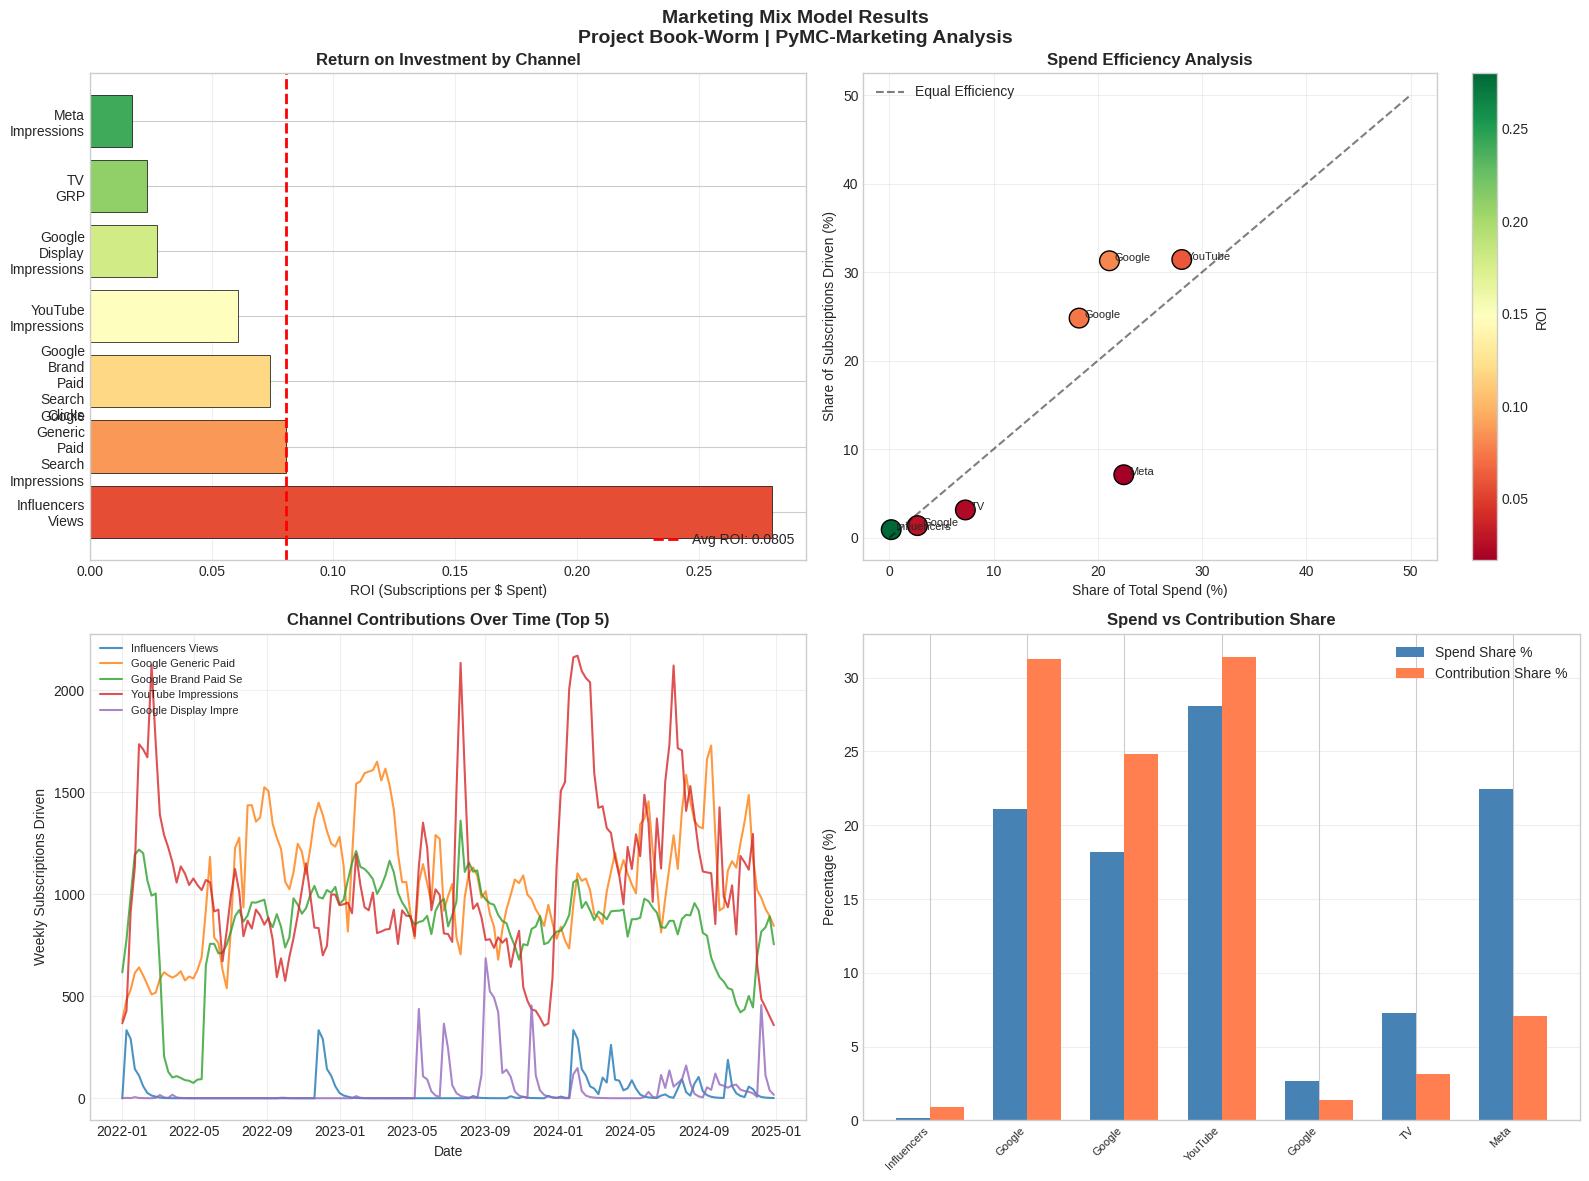

In [10]:
if __name__ == "__main__":
    mmm, results, recommendations = main()